In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import requests
import json

import plotly.express as px

%matplotlib inline

In [5]:
# API url for COVID-19 confirmed cases in US.
url = 'https://api.covid19api.com/total/country/united-states/status/confirmed'
url = url + "?format=json"

In [6]:
# Execute GET request.
requests.get(url)

<Response [200]>

In [7]:
# Get content.
response_data = requests.get(url)
response_content = response_data.content

In [8]:
# Format data as a json file.
data = response_data.json()
print(json.dumps(data, indent = 4))

[
    {
        "Country": "United States of America",
        "CountryCode": "",
        "Province": "",
        "City": "",
        "CityCode": "",
        "Lat": "0",
        "Lon": "0",
        "Cases": 1,
        "Status": "confirmed",
        "Date": "2020-01-22T00:00:00Z"
    },
    {
        "Country": "United States of America",
        "CountryCode": "",
        "Province": "",
        "City": "",
        "CityCode": "",
        "Lat": "0",
        "Lon": "0",
        "Cases": 1,
        "Status": "confirmed",
        "Date": "2020-01-23T00:00:00Z"
    },
    {
        "Country": "United States of America",
        "CountryCode": "",
        "Province": "",
        "City": "",
        "CityCode": "",
        "Lat": "0",
        "Lon": "0",
        "Cases": 2,
        "Status": "confirmed",
        "Date": "2020-01-24T00:00:00Z"
    },
    {
        "Country": "United States of America",
        "CountryCode": "",
        "Province": "",
        "City": "",
        "CityCode":

In [9]:
# Extract confirmed cases and date data from json file.
case = []
date = []
for item in data:
    case.append(item['Cases'])
for item in data:
    date.append(item['Date'])

In [10]:
# Format into DataFrame
df = pd.DataFrame(case)
df_date = pd.DataFrame(date)

In [15]:
# Import S&P500 and format it into DataFrame
SP500_hist_csv = Path("^GSPC.csv")
SP500_data = pd.read_csv(SP500_hist_csv, parse_dates=True, infer_datetime_format=True)
SP500_data['Date'] = pd.to_datetime(SP500_data['Date']).dt.date
SP500_data = SP500_data.set_index('Date').sort_index(ascending = True)
SP500_data = SP500_data.pivot_table(values="Close", index="Date")
SP500_data.head()

,Close
Date,
2019-01-22,2632.899902
2019-01-23,2638.699951
2019-01-24,2642.330078
2019-01-25,2664.760010
2019-01-28,2643.850098


In [17]:
# Concatenate DataFrames into a single DataFrame
joined_df = pd.concat([df, df_date], axis = 'columns', join='inner')
joined_df.columns = ['Case', 'Date']
joined_df = joined_df.set_index(pd.to_datetime(joined_df["Date"], infer_datetime_format = True))
joined_df = joined_df.drop(columns = ['Date'])
case_sp500 = pd.concat([joined_df, SP500_data], axis = 'columns', join = 'inner')
case_sp500['Daily Case'] = joined_df['Case'].diff()

# Reorder columns
case_sp500 = case_sp500[['Case', 'Daily Case', 'Close']]
case_sp500.head()

,Case,Daily Case,Close
Date,,,
2020-01-22,1,NaN,3321.750000
2020-01-23,1,0.0,3325.540039
2020-01-24,2,1.0,3295.469971
2020-01-27,5,0.0,3243.629883
2020-01-28,5,0.0,3276.239990


In [21]:
# Calculate percentage change for daily case and close price of S&P500
daily_pct_change = case_sp500.pct_change()
daily_pct_change = daily_pct_change.replace([np.inf, -np.inf], np.nan)
daily_pct_change.dropna(inplace = True)
daily_pct_change = daily_pct_change.drop(columns = ['Case'])
# daily_pct_change.plot(figsize = (20,10))
daily_pct_change

,Daily Case,Close
Date,,
2020-01-27,-1.000000,-0.015731
2020-02-03,0.500000,0.007255
2020-02-04,-1.000000,0.014980
2020-02-12,-1.000000,0.006463
2020-02-14,-1.000000,0.001844
...,...,...
2020-07-20,-0.141717,0.008407
2020-07-21,0.050751,0.001679
2020-07-22,0.098801,0.005747


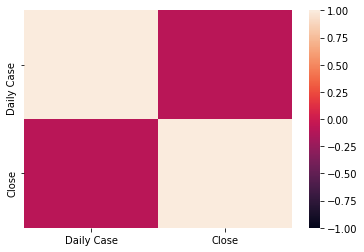

In [19]:
# Calculate and plot correlation between percentage change of daily case and close price of S&P500
correlation = daily_pct_change.corr()
sns.heatmap(correlation, vmin = -1, vmax = 1)

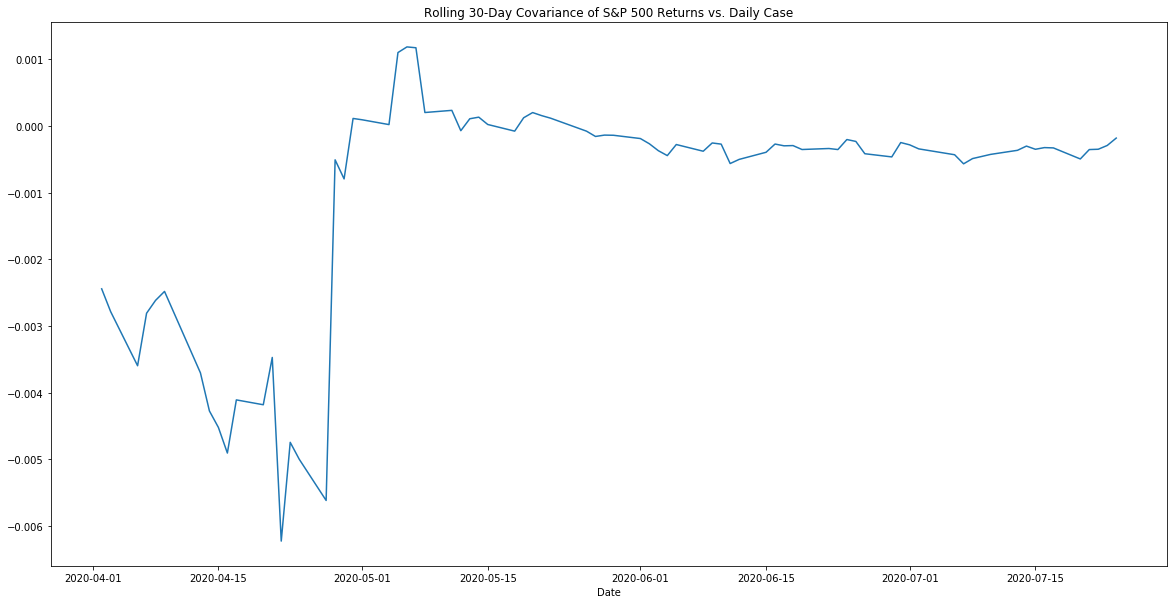

In [20]:
# Fitting rolling 30-Day Covariance of S&P 500 Returns vs. Daily Case
rolling_covariance = daily_pct_change['Close'].rolling(window=30).cov(daily_pct_change['Daily Case'])
rolling_covariance.plot(figsize=(20, 10), title='Rolling 30-Day Covariance of S&P 500 Returns vs. Daily Case')

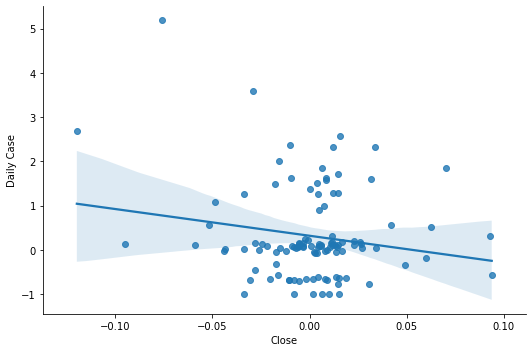

In [161]:
# Fitting regression line
sns.lmplot(x="Close", y="Daily Case", data=daily_pct_change, aspect=1.5, fit_reg=True)

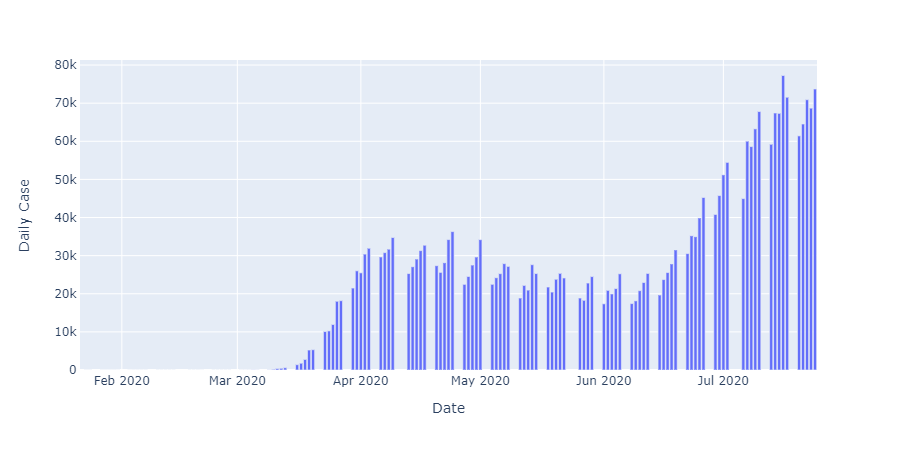

In [26]:
new_df = case_sp500.reset_index()
fig = px.bar(new_df,x="Date", y="Daily Case")
fig.show()